In [6]:
from PIL import Image, ImageDraw, ImageFilter, ImageChops
import face_recognition
import random
import colorsys
import numpy as np
from block_distortion import distort_image


def label_landmarks(image, landmark_list):
    """
    Labels facial landmarks on a PIL image.

    Args:
        image (PIL.Image.Image): The input image.
        landmarks (dict): A dictionary of facial landmarks.

    Returns:
        PIL.Image.Image: The image with labeled landmarks.
    """

    if type(landmark_list) != list:
        landmark_list = [landmark_list]
    draw = ImageDraw.Draw(image)
    for landmarks in landmark_list:
        for landmark_type, points in landmarks.items():
            # Generate a unique color for each landmark type
            if landmark_type == "bottom_lip":
                continue
            hue = float(hash(landmark_type)) % 360 / 360
            saturation = 0.8
            lightness = 0.5
            start_color = [
                int(c * 255) for c in colorsys.hsv_to_rgb(hue, saturation, lightness)
            ]

            # Draw each point with a slightly different shade of the same color
            num_points = len(points)
            for i, (x, y) in enumerate(points):
                color_step = i / num_points
                current_color = [
                    int(c * (1 - color_step) + 255 * color_step) for c in start_color
                ]
                draw.text((x, y), str(i), fill=tuple(current_color), stroke_width=1)
    return image


# face_landmarks_list = face_recognition.face_landmarks(image, model="large")
# pil_image = Image.fromarray(image).copy()
# label_landmarks(pil_image, face_landmarks_list)


def bounding_box(array):
    array = np.array(array)
    x_min = min(array[:, 0])
    x_max = max(array[:, 0])
    y_min = min(array[:, 1])
    y_max = max(array[:, 1])
    return (x_min, y_min, x_max, y_max)


def box_crop(box, array):
    x_min, x_max, y_min, y_max = box
    print("box_crop array shape", array.shape)
    array = array[y_min:y_max, x_min:x_max]
    print("box_crop array shape after cropping", array.shape)
    return array


def extract_polygon_region(image, polygon):
    """
    Extracts a polygonal region from an image.

    Args:
        image (PIL.Image.Image): The input image.
        polygon (list): List of (x, y) coordinates defining the polygon.

    Returns:
        PIL.Image.Image: The extracted polygonal region as a new image.
    """

    mask_im = Image.new("L", (image.width, image.height), 0)
    ImageDraw.Draw(mask_im).polygon(polygon, outline=1, fill=1)
    mask = np.array(mask_im)

    # Apply mask to extract the region
    image_array = np.array(image)
    masked_array = image_array * np.expand_dims(mask, axis=2)
    region_image = masked_array.astype(np.uint8)

    return region_image


def surreal_eye(image, landmarks):
    """
    Creates a surreal composite eye effect on the input image.

    Args:
        image (PIL.Image.Image): The input image.
        landmarks (dict): Facial landmarks dictionary.

    Returns:
        PIL.Image.Image: The image with the surreal eye effect applied.
    """

    image = image.copy()
    # Extract eye landmarks
    left_eye = landmarks["left_eye"]
    right_eye = landmarks["right_eye"]
    mid_eye = (
        int(0.5 * (right_eye[3][0] + left_eye[0][0])),
        int(0.5 * (right_eye[3][1] + left_eye[0][1])),
    )

    # 1. Copy eye regions
    left_eye_polygon = [(x, y) for x, y in left_eye]
    right_eye_polygon = [(x, y) for x, y in right_eye]

    left_eye_image = Image.fromarray(extract_polygon_region(image, left_eye_polygon))
    left_eye_image = left_eye_image.crop(bounding_box(left_eye_polygon))

    right_eye_image = Image.fromarray(extract_polygon_region(image, right_eye_polygon))
    right_eye_image = right_eye_image.crop(bounding_box(right_eye_polygon))

    # 2. Stretch eyes
    target_width = int(
        1.1 * max(left_eye[3][0] - left_eye[0][0], right_eye[3][0] - right_eye[0][0])
    )
    target_height = int(
        1.1
        * max(
            left_eye[1][1] - left_eye[5][1],
            left_eye[4][1] - left_eye[2][1],
            right_eye[1][1] - right_eye[5][1],
            right_eye[4][1] - right_eye[2][1],
        )
    )

    left_eye_image = left_eye_image.resize((target_width, target_height), Image.LANCZOS)
    right_eye_image = right_eye_image.resize(
        (target_width, target_height), Image.LANCZOS
    )

    # 3. Create composite eye
    composite_eye = left_eye_image
    composite_eye = ImageChops.blend(left_eye_image, right_eye_image, 0.5)
    composite_eye_width = int(1.1 * (right_eye[3][0] - left_eye[0][0]))
    composite_eye_height = int(target_height * (composite_eye_width / target_width))
    composite_eye = composite_eye.resize(
        (composite_eye_width, composite_eye_height), Image.LANCZOS
    )

    # 4. Create black ellipse
    ellipse_width, ellipse_height = 1.5 * composite_eye_width, 4 * composite_eye_height

    ellipse_mask = Image.new("RGB", image.size, (255, 255, 255))
    ellipse_draw = ImageDraw.Draw(ellipse_mask)
    x_min, y_min = mid_eye[0] - ellipse_width // 2, mid_eye[1] - ellipse_height // 2
    ellipse_draw.ellipse(
        [(x_min, y_min), (x_min + ellipse_width, y_min + ellipse_height)],
        fill=(0, 0, 0),
    )

    ellipse_mask = ellipse_mask.filter(
        ImageFilter.GaussianBlur(radius=int(0.05 * composite_eye.width))
    )
    image = ImageChops.multiply(ellipse_mask, image)

    # 5. Add composite eye to image
    composite_eye_width, composite_eye_height = int(1.2 * composite_eye_width), int(
        1.5 * composite_eye_height
    )
    composite_eye = composite_eye.resize(
        (composite_eye_width, composite_eye_height), Image.LANCZOS
    )
    composite_eye = composite_eye.filter(
        ImageFilter.UnsharpMask(radius=composite_eye_width // 10, percent=200)
    )
    composite_eye_layer = Image.new("RGB", image.size, (0, 0, 0))
    composite_eye_layer_array = np.array(composite_eye_layer)

    x_min, y_min = (
        mid_eye[0] - composite_eye_width // 2,
        mid_eye[1] - composite_eye_height // 2,
    )
    x_max, y_max = x_min + composite_eye_width, y_min + composite_eye_height

    composite_eye_layer_array[y_min:y_max, x_min:x_max] = np.array(composite_eye)
    composite_eye_layer = Image.fromarray(composite_eye_layer_array)
    image = ImageChops.add(composite_eye_layer, image)
    return image


def draw_mouth_cross(
    image,
    landmarks,
    jitter_ratio=0.35,
    line_count=10,
    color=(132, 18, 18, 122),
    alpha=0.6,
):
    """
    Draws a cross over the mouth region of an image using facial landmarks.

    Args:
      image (PIL.Image.Image): The input image.
      landmarks (dict): A dictionary of facial landmarks.
      jitter_ratio (float): The ratio of random jitter applied to line endpoints.

    Returns:
      PIL.Image.Image: The image with the mouth cross drawn.
    """

    chin = np.array(landmarks["chin"])
    face_width = chin[15, 0] - chin[1, 0]
    upper_lip = np.array(landmarks["top_lip"])
    lower_lip = np.array(landmarks["bottom_lip"])
    lip_left_corner = (upper_lip[0] + lower_lip[1]) / 2
    lip_right_corner = (upper_lip[6] + lower_lip[0]) / 2
    lip_height = upper_lip[3, 1] - lower_lip[3, 1]

    def draw_jittered_line(image, p1, p2, jitter_ratio, linewidth, color):
        dx = p2[0] - p1[0]
        dy = p2[1] - p1[1]

        jitter_x = int(jitter_ratio * abs(dx))
        jitter_y = int(jitter_ratio * abs(dy))

        p1_jittered = (
            p1[0] - dx * jitter_ratio + random.randint(-jitter_x, jitter_x),
            p1[1] - dy * jitter_ratio + random.randint(-jitter_y, jitter_y),
        )
        p2_jittered = (
            p2[0] + dx * jitter_ratio + random.randint(-jitter_x, jitter_x),
            p2[1] + dy * jitter_ratio + random.randint(-jitter_y, jitter_y),
        )

        draw = ImageDraw.Draw(image)
        draw.line([p1_jittered, p2_jittered], fill=color, width=linewidth)

    def draw_jittered_line_alpha(image, p1, p2, jitter_ratio, linewidth, alpha, color):
        original = image.copy()
        ImageChops.blend(image, original, alpha)
        dx = p2[0] - p1[0]
        dy = p2[1] - p1[1]

        jitter_x = int(jitter_ratio * abs(dx))
        jitter_y = int(jitter_ratio * abs(dy))

        p1_jittered = (
            p1[0] - dx * jitter_ratio + random.randint(-jitter_x, jitter_x),
            p1[1] - dy * jitter_ratio + random.randint(-jitter_y, jitter_y),
        )
        p2_jittered = (
            p2[0] + dx * jitter_ratio + random.randint(-jitter_x, jitter_x),
            p2[1] + dy * jitter_ratio + random.randint(-jitter_y, jitter_y),
        )

        draw = ImageDraw.Draw(image)
        draw.line([p1_jittered, p2_jittered], fill=color, width=linewidth)
        return ImageChops.blend(original, image, alpha)

    # Draw crosses
    linewidth = face_width // 50

    upper_left_corner = (4 * upper_lip[1] + chin[1]) // 5
    lower_left_corner = (4 * lower_lip[5] + chin[5]) // 5
    upper_right_corner = (4 * upper_lip[5] + chin[15]) // 5
    lower_right_corner = (4 * lower_lip[1] + chin[10]) // 5
    for _ in range(line_count):
        draw_jittered_line(
            image, upper_left_corner, lower_right_corner, jitter_ratio, linewidth, color
        )
        draw_jittered_line(
            image, lower_left_corner, upper_right_corner, jitter_ratio, linewidth, color
        )

    return image


def apply_filter(image):
    image = np.array(image.convert("RGB")).astype(np.uint8)
    face_landmarks_list = face_recognition.face_landmarks(image)
    split_image = (255 * distort_image(image.astype(np.float32), splits=10000)).astype(
        np.uint8
    )
    pil_split_image = Image.fromarray(split_image)
    pil_image = Image.fromarray(image)

    for face_landmarks in face_landmarks_list:
        pil_image = surreal_eye(pil_image, face_landmarks)
        pil_image = draw_mouth_cross(pil_image, face_landmarks)
    return ImageChops.darker(ImageChops.overlay(pil_split_image, pil_image), pil_image)


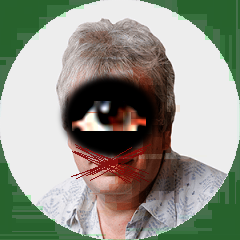

In [7]:
im = Image.open("test_image.png")
apply_filter(im)

In [8]:
from bs4 import BeautifulSoup
import base64
from io import BytesIO
from PIL import Image
from custom_filter import apply_filter


def process_html_images(html_path, output_path):
    with open(html_path, "r") as f:
        html_content = f.read()

    soup = BeautifulSoup(html_content, "html.parser")

    for img_tag in soup.find_all("img"):
        data_image = img_tag.get("src")
        if data_image and data_image.startswith("data:image"):
            header, encoded = data_image.split(",", 1)
            image_type = header.split(";")[0].split("/")[1]
            if image_type in ["png", "jpg", "jpeg"]:
                try:
                    decoded = base64.b64decode(encoded)
                    image = Image.open(BytesIO(decoded))
                    filtered_image = apply_filter(image)

                    buffered = BytesIO()
                    filtered_image.save(buffered, format=image_type)
                    encoded_filtered = base64.b64encode(buffered.getvalue()).decode()
                    img_tag["src"] = (
                        f"data:image/{image_type};base64,{encoded_filtered}"
                    )
                except Exception as e:
                    print(f"Error processing image: {e}")

    with open(output_path, "w") as f:
        f.write(str(soup))

process_html_images("The Times.html", "modified_The Times.html")

Error processing image: height and width must be > 0
Error processing image: height and width must be > 0
Error processing image: could not broadcast input array from shape (16,80,3) into shape (16,0,3)


In [ ]:
# import re
# from bs4 import BeautifulSoup
# import nltk
# import random

# nltk.download('punkt_tab')
# nltk.download('averaged_perceptron_tagger_eng')

# def process_html_text(html_path, output_path, word_list):
#     with open(html_path, "r") as f:
#         html_content = f.read()
#     soup = BeautifulSoup(html_content, 'html.parser')
    
#     noun_list = word_list['noun']
#     verb_list = word_list['verb']
#     adj_list = word_list['adj']
    
#     for element in soup.find_all(text=True):
#         if element.parent.name not in ['script', 'style']:
#             stripped_text = element.strip()
#             if stripped_text:
#                 tokens = nltk.word_tokenize(stripped_text)
#                 tagged_tokens = nltk.pos_tag(tokens)
#                 modified_text = []
#                 for token, tag in tagged_tokens:
#                     if tag.startswith('NN'):
#                         random_noun = random.choice(noun_list)
#                         if token[0].isupper():
#                             random_noun = random_noun.capitalize()
#                         elif token.isupper():
#                             random_noun = random_noun.upper()
#                         modified_text.append(random_noun)
#                     elif tag.startswith('JJ'):
#                         random_noun = random.choice(verb_list)
#                         if token[0].isupper():
#                             random_noun = random_noun.capitalize()
#                         elif token.isupper():
#                             random_noun = random_noun.upper()
#                         modified_text.append(random_noun)
#                     elif tag.startswith('VBZ'):
#                         random_noun = random.choice(adj_list)
#                         if token[0].isupper():
#                             random_noun = random_noun.capitalize()
#                         elif token.isupper():
#                             random_noun = random_noun.upper()
#                         modified_text.append(random_noun)
#                     else:
#                         modified_text.append(token)
#                 modified_text = " ".join(modified_text)
#                 modified_text = re.sub(r' ([\.,\'"?!\):;”’])', r'\1', modified_text)
#                 modified_text = re.sub(r'([‘“]) ', r'\1', modified_text)
#                 element.replace_with(modified_text)

#     with open(output_path, "w") as f:
#         f.write(str(soup))
#     return

In [69]:
import re
from bs4 import BeautifulSoup
import nltk
from tqdm import tqdm

nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

def process_html_text(html_path, output_path, word_list):
    with open(html_path, "r") as f:
        html_content = f.read()
    soup = BeautifulSoup(html_content, 'html.parser')
    
    for element in tqdm(soup.find_all(text=True)):
        if element.parent.name not in ['script', 'style']:
            stripped_text = element.strip()
            if stripped_text:
                element.replace_with(_modify_text(stripped_text, word_list))

    with open(output_path, "w") as f:
        f.write(str(soup))

def _modify_text(text, word_list):
    tokens = nltk.word_tokenize(text)
    tagged_tokens = nltk.pos_tag(tokens)
    modified_text = []
    for token, tag in tagged_tokens:
        if tag.startswith('NN'):
            replacement = random.choice(word_list['noun'])
        elif tag.startswith('JJ'):
            replacement = random.choice(word_list['verb'])
        elif tag.startswith('VBZ'):
            replacement = random.choice(word_list['adj'])
        else:
            replacement = token
        modified_text.append(replacement if token.islower() else _match_case(token, replacement))
    modified_text = " ".join(modified_text)
    modified_text = re.sub(r' ([\.,\'"?!\):;”’])', r'\1', modified_text)
    return re.sub(r'([‘“]) ', r'\1', modified_text)

def _match_case(source, target):
    if source.isupper():
        return target.upper()
    elif source[0].isupper():
        return target.capitalize()
    return target

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/deadscholar/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/deadscholar/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [70]:
noun_list = ['illusion', 'remnant', 'augury', 'insanity', 'extermination', 'mayhem', 'carnage', 'epitaph', 'corpse', 'bafflement', 'chaos', 'conflict', 'mystery', 'rejection', 'horror', 'cessation', 'desolation', 'graveyard', 'decline', 'limbo', 'apprehension', 'tomb', 'desecration', 'confusion', 'dilemma', 'chill', 'malaise', 'destiny', 'absurdity', 'eulogy', 'strife', 'puzzle', 'precipice', 'disdain', 'loneliness', 'mockery', 'decay', 'incoherence', 'fear', 'havoc', 'shadow', 'elegy', 'mausoleum', 'plight', 'dread', 'skepticism', 'charnel', 'pandemonium', 'annihilation', 'darkness', 'fatalism', 'reverie', 'remembrance', 'massacre', 'misery', 'resignation', 'eradication', 'wraith', 'cliff', 'phantasm', 'chasm', 'panic', 'nightmare', 'lamentation', 'mortality', 'skull', 'blackness', 'oblivion', 'destruction', 'recollection', 'ambiguity', 'skeleton', 'carcass', 'mirage', 'tension', 'derision', 'ridicule', 'doubt', 'sarcasm', 'pessimism', 'crypt', 'heresy', 'heresiarch', 'delusion', 'bewilderment', 'murk', 'barrenness', 'extinction', 'reservation', 'fatality', 'renunciation', 'bones', 'ghost', 'tumult', 'murkiness', 'purposelessness', 'conundrum', 'disbelief', 'distress', 'doom', 'brink', 'disintegrate', 'fog', 'disdain', 'paradox', 'irrationality', 'perdition', 'sacrilege', 'despair', 'shock', 'woe', 'dissolve', 'silence', 'premonition', 'isolation', 'vacuum', 'delirium', 'trance', 'discord', 'futility', 'house', 'omen', 'eeriness', 'surrender', 'anxiety', 'curse', 'remorse', 'dirge', 'devastation', 'torment', 'heartache', 'ruin', 'gloom', 'abandonment', 'bereavement', 'pass', 'relinquishment', 'desertion', 'tremor', 'obscurity', 'mystification', 'termination', 'grief', 'forsake', 'cynicism', 'repudiation', 'expire', 'fate', 'terror', 'solitude', 'whispers', 'uncertainty', 'sorrow', 'nihilism', 'catacomb', 'purgatory', 'obliteration', 'turmoil', 'contempt', 'specter', 'repudiate', 'meaninglessness', 'despondency', 'limit', 'absence', 'reluctance', 'madness', 'blasphemy', 'haunting', 'hesitation', 'expiration', 'mist', 'coldness', 'slaughter', 'cemetery', 'memory', 'profanity', 'angst', 'capitulation', 'perish', 'desert', 'enigma', 'consternation', 'verge', 'fall', 'apparition', 'predicament', 'shadows', 'remains', 'echoes', 'labyrinth', 'crevasse', 'flaw', 'wistfulness', 'ossuary', 'void', 'haze', 'ennui', 'edge', 'regret', 'quandary', 'abyss', 'banshee', 'whimsy', 'unrest', 'vestige', 'finale', 'boundary', 'relic', 'fright', 'melancholy', 'anguish', 'necropolis', 'apostasy', 'twilight', 'phantom', 'echo', 'gloominess', 'burial', 'dusk', 'end', 'prophecy', 'emptiness', 'cloud', 'vortex', 'disillusionment', 'disappearance', 'disintegration', 'disrespect', 'rejection', 'star', 'sun', 'moon', 'underground', 'daemon', 'angel', 'ophanim', 'cherubim', 'seraphim', 'blade', 'dagger', 'scalpel', 'blood', 'flame']
verb_list = ['disrespect', 'reject', 'vanish', 'evaporate', 'languish', 'misgive', 'deteriorate', 'crumble', 'long', 'relinquish', 'dwindle', 'end', 'renounce', 'ground', 'abandon', 'haunt', 'eclipse', 'fade', 'resign', 'remember', 'dream', 'spin', 'yield', 'wither', 'concern', 'trace', 'recollect', 'capitulate', 'dismay', 'delude', 'deaden', 'devastate' 'mourn', 'hypnotize', 'doom', 'isolate', 'prophesize', 'dissipate', 'pine', 'alarm', 'ruin', 'curse', 'grieve', 'hesitate', 'expire', 'void', 'blaspheme', 'slither', 'awaken']
adj_list = ['forsaken', 'hollow', 'spinning', 'anxious', 'foggy', 'skeletal', 'mortal', 'immortal', 'unknown', 'recovered', 'succumb', 'heterodox', 'oceanic', 'dark', 'past', 'broken', 'expiring', 'null', 'void', 'enigmatic', 'cold', 'dismal', 'fading', 'dying', 'lost', 'forgotten', 'haunted', 'eclipsed', 'fading', 'resigned', 'dreaming', 'spinning', 'yielding', 'withering', 'tracing', 'recollecting', 'capitulating', 'dismaying', 'deluding', 'devastating', 'mourning', 'hypnotizing', 'dooming', 'isolating', 'prophesizing', 'dissipating', 'pining', 'alarming', 'ruining', 'cursing', 'grieving', 'hesitating', 'expiring', 'expired', 'solemn', 'depressing', 'dreary', 'abysmal', 'vestigial', 'twinkling', 'subtle', 'asleep', 'aflame']
word_lists = {'noun': noun_list, 'verb': verb_list, 'adj': adj_list}
process_html_text("modified_Albert Einstein - Wikipedia.html", "modified_Albert Einstein - Wikipedia.html", word_lists)

/tmp/ipykernel_13261/2619321649.py:14: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  for element in tqdm(soup.find_all(text=True)):
100%|█████████████████████████████████████████████████████████████████████████████| 12022/12022 [13:37<00:00, 14.71it/s]
